# import and useful functions

In [1]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


from keras import backend as K
K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [3]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [4]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [5]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

# Data Visualisation

In [6]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [7]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [8]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [9]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

### Preprocessing

In [10]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"chest_xray/"
output_directory = r"data_output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"data_output/figures"

figure_directory = "data_output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


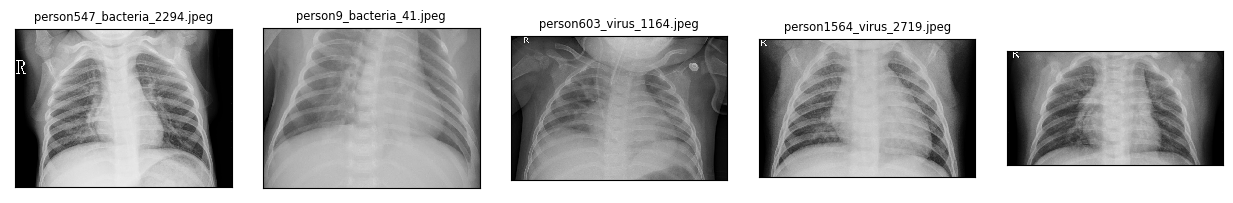


-------------------------------------------------------Normal-------------------------------------------------------


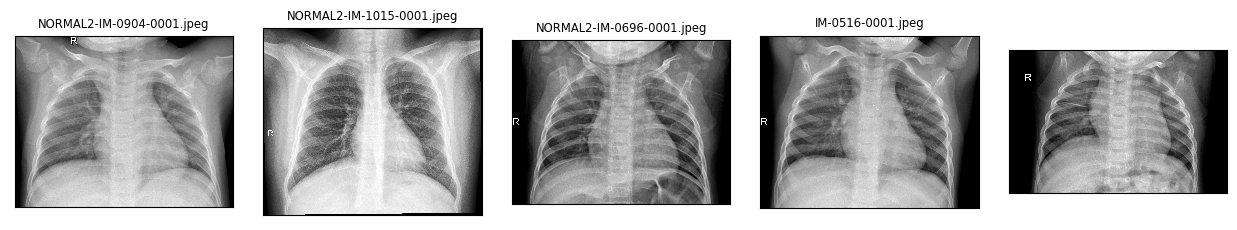


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [11]:
show_class_sample_images(training_dir)

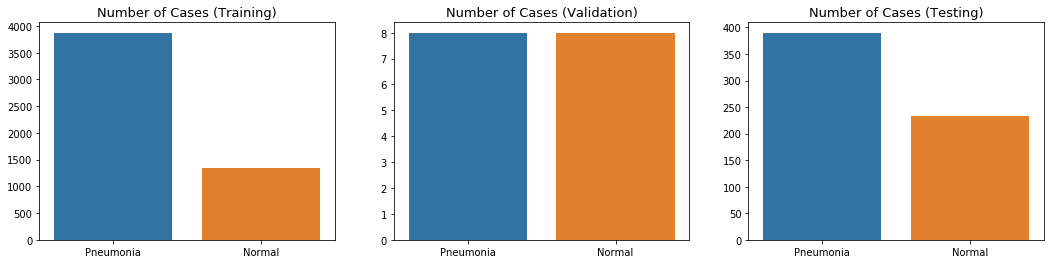

In [12]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

### Image Preprocessing

In [13]:
# batch_size = 32

# target_size = (299, 299)
# color_mode = "rgb"


rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [15]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [16]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

create_directory(main_model_dir)
create_directory(main_log_dir)


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Could not create directory:  data_output/models/
Could not create directory:  data_output/logs/


In [17]:
reset_graph()
reset_callbacks()

W0926 22:00:23.415958 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0926 22:00:23.416827 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0926 22:00:23.445008 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
print("Settting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ", date_time(1))

Settting Callbacks at  Timestamp: 2019-09-26 22:00:23
Set Callbacks at  Timestamp: 2019-09-26 22:00:24


### Training and fine-tuning for new labels

In [19]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    
#     x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    
#     x = Dense(512, activation='relu')(x)
    #x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

In [20]:
print("Getting Base Model", date_time(1))
model = get_model()

W0926 22:00:24.236336 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 22:00:24.238955 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Getting Base Model Timestamp: 2019-09-26 22:00:24


W0926 22:00:24.644048 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0926 22:00:25.355526 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, None, None 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, None, Non 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, None, Non 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, None, Non 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
print("Starting Trainning Model", date_time(1))


steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)





optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 20


model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time(1))


W0926 22:00:37.177304 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0926 22:00:37.260261 140278642575104 deprecation.py:323] From /home/bru/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Starting Trainning Model Timestamp: 2019-09-26 22:00:37


W0926 22:00:38.472733 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0926 22:00:38.473346 140278642575104 deprecation_wrapper.py:119] From /home/bru/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
 - 129s - loss: 0.4254 - acc: 0.8085 - val_loss: 1.3737 - val_acc: 0.6250
Epoch 2/20
 - 121s - loss: 0.2703 - acc: 0.8905 - val_loss: 1.3371 - val_acc: 0.6875
Epoch 3/20
 - 122s - loss: 0.2337 - acc: 0.9078 - val_loss: 1.6715 - val_acc: 0.5625
Epoch 4/20
 - 122s - loss: 0.2229 - acc: 0.9095 - val_loss: 2.6983 - val_acc: 0.5625
Epoch 5/20
 - 130s - loss: 0.2137 - acc: 0.9130 - val_loss: 3.1305 - val_acc: 0.5625
Epoch 6/20
 - 156s - loss: 0.2092 - acc: 0.9133 - val_loss: 3.0496 - val_acc: 0.5625
Epoch 7/20
 - 150s - loss: 0.2034 - acc: 0.9197 - val_loss: 4.7547 - val_acc: 0.5000

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
Completed Model Trainning Timestamp: 2019-09-26 22:16:39


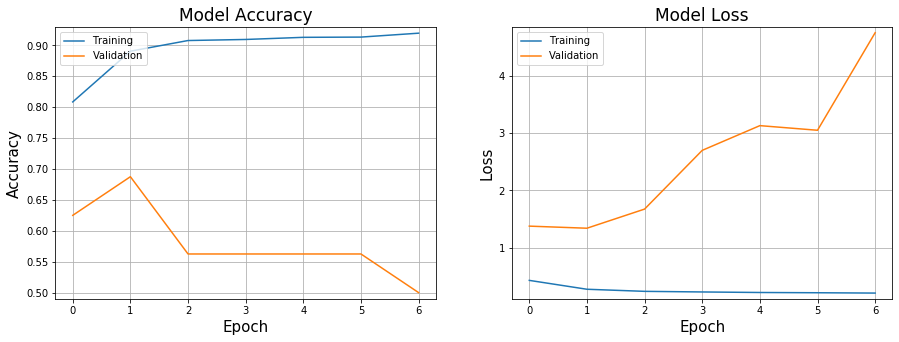

In [22]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [23]:
dir_name = r"data_output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2019-09-22 20-30-02
1 2019-09-26 22-00-23
2 2019-09-23 17-12-17
3 2019-09-21 17-03-39


In [24]:
cur_dir =dir_name+dirs[0]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 06-val_acc-0.75-val_loss-1.49.hdf5
1 01-val_acc-0.62-val_loss-2.96.hdf5
2 02-val_acc-0.81-val_loss-1.19.hdf5
3 02-val_acc-0.69-val_loss-1.52.hdf5


In [25]:
model_file = cur_dir+model_names[0]

print(model_file)

data_output/models/2019-09-22 20-30-02/06-val_acc-0.75-val_loss-1.49.hdf5


In [26]:
model = keras.models.load_model(model_file)

In [27]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 32s 32s/step
Loss     : 1.24  
Accuracy : 70.67%


### Visualization

In [34]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [35]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)



image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()



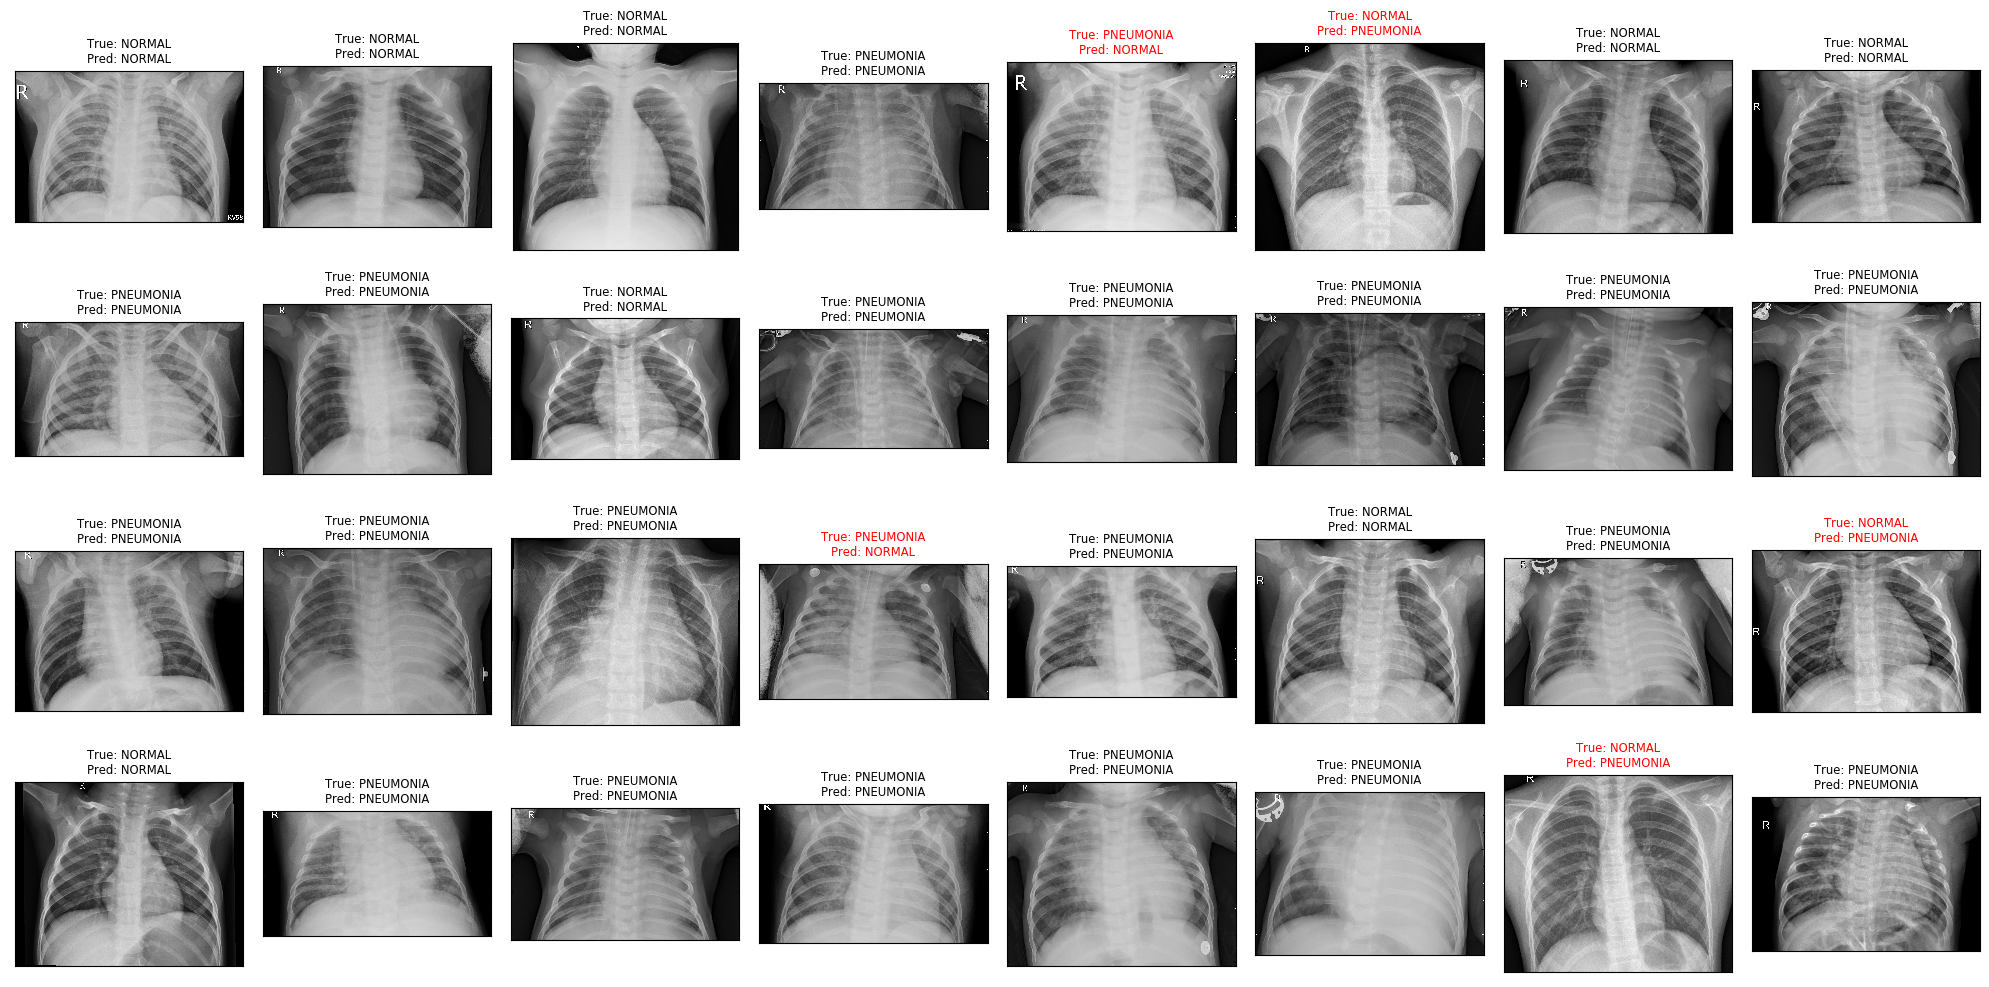

In [36]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)